# Lab 4: Logistic Regression

In this assignment, we will learn the Logistic Regression model.

First, please study the given example, which uses the logistic regression model for the breast cancer classification task. In this example, you will learn how to preprocess data, how to train the model, and how to evaluate the model.

Based on the given example, your task is to use the logistic regression model to predict the presence of heart disease.


## 1. Example

### 1.1 Load the breast cancer data

Here, we use the [breast cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer) dataset in sklearn. It is a binary classification dataset. Each sample has 30 numerical features, which can be found in [7.1.7](https://scikit-learn.org/stable/datasets/toy_dataset.html).

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from random import shuffle
import random
random.seed(123)

X, y = datasets.load_breast_cancer(return_X_y=True)
print("#samples: {}, #features: {}".format(X.shape[0], X.shape[1]))

#samples: 569, #features: 30


### 1.2 Split the data into two subsets and normalize the features of samples

Here, we use 69 samples as the testing set and use the remained samples to train the logistic regression model. 

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.12, 
                                                            random_state=0)
print("train_val: {}, test: {}".format(X_train_val.shape[0], X_test.shape[0]))

normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)


train_val: 500, test: 69


### 1.3 Train the logistic regression model and select the hyperparameter with cross-validation

Here, we use the following logistic regression model to do cancer classification. 

\begin{equation}
	\min_{\mathbf{w}} \sum_{i=1}^{n}\{\log(1+\exp(\mathbf{w}^T\mathbf{x}_i))-y_i\mathbf{w}^T\mathbf{x}_i \} + \lambda\|\mathbf{w}\|_2^2
\end{equation}

We need to learn the model parameter $\mathbf{w}$. However, with different hyperparameters $\lambda$, we can get different model parameter $\mathbf{w}$, resulting in different prediction performance. Here, we use the 5-fold cross-validation to select the hyperparameter $\lambda$.

In [ ]:
# seed the shuffler
# restated this line because otherwise, the shuffling was not consistent
random.seed(123)

# here we use 5-fold cross-validation
folds = 5

# get the number of samples in the training and validation set
num_train_val = X_train_val.shape[0] 

# shuffle the index of samples in the train_val set
index_of_samples = np.arange(num_train_val) 
shuffle(index_of_samples)

# split the index of the train_valid set into 5 folds
index_of_folds = index_of_samples.reshape(folds, -1)
print(index_of_folds)

# potential hyperparameters. 
reg_coeff_dB_radius = 20
reg_coeff_dB = np.array(range((-reg_coeff_dB_radius), (1 + reg_coeff_dB_radius)))
regularization_coefficient = 10**(reg_coeff_dB/20)

best_acc = 0.0
best_reg = 0.0

for reg in regularization_coefficient:
    
    # 5-fold cross-validation
    sum_acc = 0.0
    for fold in range(folds):
        
        index_of_folds_temp = index_of_folds.copy()
        
        valid_index = index_of_folds_temp[fold,:].reshape(-1) #get the index of the validation set
        train_index = np.delete(index_of_folds_temp, fold, 0).reshape(-1) #get the index of the training set
        
        # training set
        X_train = X_train_val[train_index]
        y_train = y_train_val[train_index]
        
        # validation set
        X_valid = X_train_val[valid_index]
        y_valid = y_train_val[valid_index]
                
        # build the model with different hyperparameters
        clf = LogisticRegression(penalty='l2', C=reg, solver='lbfgs')
        
        #train the model with the training set
        clf.fit(X_train, y_train)
        
        y_valid_pred = clf.predict(X_valid)
        acc = accuracy_score(y_valid, y_valid_pred)
        
        sum_acc += acc
    
    cur_acc = sum_acc / folds
    
    print("reg_coeff: {}, acc: {:.3f}".format(1.0/reg, cur_acc))
    
    # store the best hyperparameter
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_reg = reg
        
print('best reg coeff:', 1.0/best_reg)

[[380 468 145   2 282 103 148 312 130 411 168 204 113 132 418 270 351 157
  451 339 288 277 354  48 318 303 314 234  95 304 271 434 173 357 495 133
  431  39 490 310 317 471  23 426 224 286  20 365 255 216 405  79 228 445
  189 184 243 358 276 218 488  60 438 159 167 349  89 121 333  51   9 482
  152 416 379 306 111 185 340 489 475  93  84 376 291 158 250 323 406 460
   50 433 372  66 108 465  71 298 369 437]
 [211  11 110 142  28  59 163  38  24 205 440 140 177 252 235 245 242  25
   21 217 160 231  77 151  54 345 280 257 456 308 331  58 360 179 464 388
  129 285 347  56 387 169  36 138 319 296 246 122  33 127 109 363 183 196
  422  86 400 297 346 116  63  88 477 144 112 362 399 334  62 353 146 373
   27  76 260 150 210 195 290  82 154 432 320 361  75  17  94 238 143 469
   67 225 391 106  15  97  46  49 192 226]
 [114 302 356  91  80 107 329 209 384 409  13 176 299 483 295 491 332 292
  153 202 268   1 417 313 375 128 352  57 408 254 382 390 377 328 213 182
   65   7 315 101 187 126 

### 1.4 Evaluate the learned model

After getting the best hyperparameter $\lambda$, we retrain the model with the train_val set. Then, we evaluate this  model on the testing set. 

In [ ]:
# retrain the model
clf = LogisticRegression(penalty='l2', C=best_reg, solver='lbfgs')
clf.fit(X_train_val, y_train_val)

# evaluate the model on the testing set
y_test_pred = clf.predict(X_test)


acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)


print("accuracy: {:.3f}, recall: {:.3f}, precision: {:.3f}, f1: {:.3f},".format(acc, recall, precision, f1))

accuracy: 1.000, recall: 1.000, precision: 1.000, f1: 1.000,


## 2. Task

Here, we use the [heart disease](./heart.csv) dataset. Each sample has the following feature: 

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

The last column refers to the presence of heart disease in the patient.

The task is to predict whether a person has the heart disease. 

In [ ]:
# importing the necessary modules
import pandas as pd                 # for the dataframe
import numpy as np                  # for #arange
import matplotlib.pyplot as plt     # for various plots
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import math                         # for ceiling function
import statistics as stats          # for mean function
import random
from random import shuffle

In [ ]:
# constants
DATASET_FILENAME = r'heart.csv'     # filename of the dataset input
SEED = 42                           # randomizer for sampling, e.g., train, test data
MIN_SPARSE_P = 0.50                 # the minimum rate missing of a sparse feature

## 2.1 Preprocess the raw data

* Check whether there are missing values
* Check whether theare are cateogrical features
* Check whether this dataset is balanced or not (use the bar plot to visualize the number of positive and negative samples)


In [ ]:
# load the heart disease dataset
df = pd.read_csv(DATASET_FILENAME)
N_SAMPS, N_FEATS = df.shape
print("# samples = {}".format(N_SAMPS))
print("# features = {}".format(N_FEATS))

# print some basic information about the dataset
print('\n===data frame information===')
df.info()

# print its parameters
print('\n===data frame parameters===')
df.describe()

# samples = 303
# features = 14

===data frame information===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB

===data frame parameters===


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


From `df.info()`, we see that all of the features are numerical. Additionally, there are few examples $303 \leq 1000$. So we can inspect directly. Additionally, none are missing.

This can be more clearly demonstrated by finding the missing values.

In [ ]:
# calculate the number of missing values
n_missing = df.isnull().sum()
# calculate the rate
p_missing = n_missing/df.shape[0]

print(r'===# missing values per column===')
print(n_missing)
print()
print(r'===# missing values per column===')
print(p_missing)

# remove any sparse features
df = df.drop(df.columns[p_missing > MIN_SPARSE_P], axis = 1)

===# missing values per column===
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

===# missing values per column===
age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64


We can clearly see that there are no missing values now. However, let's look at the distributions of each feature.

===histogram of age===
min	 29
25%	 47.5
75%	 61.0
iqr	 13.5
max	 77
range	 48
width	 4.019908994408628
# bins	 12


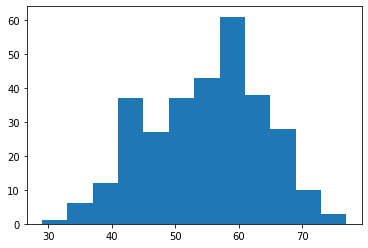


===histogram of sex===
min	 0
25%	 0.0
75%	 1.0
iqr	 1.0
max	 1
range	 1
width	 0.29777103662286136
# bins	 4


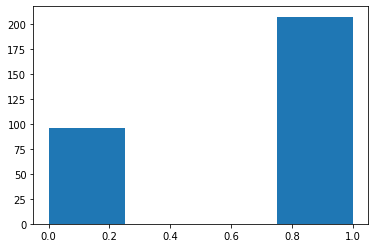


===histogram of cp===
min	 0
25%	 0.0
75%	 2.0
iqr	 2.0
max	 3
range	 3
width	 0.5955420732457227
# bins	 6


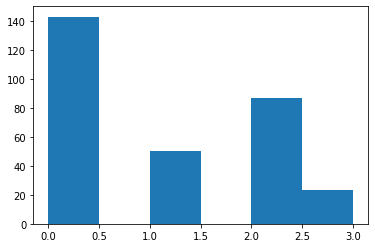


===histogram of trestbps===
min	 94
25%	 120.0
75%	 140.0
iqr	 20.0
max	 200
range	 106
width	 5.9554207324572275
# bins	 18


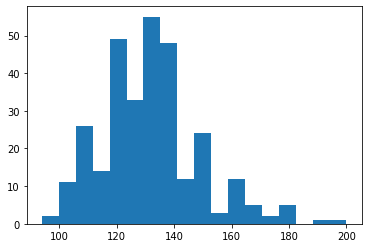


===histogram of chol===
min	 126
25%	 211.0
75%	 274.5
iqr	 63.5
max	 564
range	 438
width	 18.908460825551696
# bins	 24


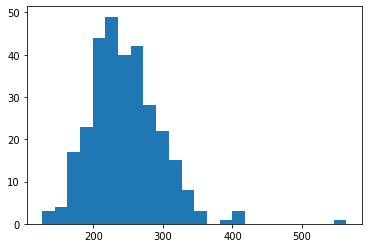


===histogram of fbs===
min	 0
25%	 0.0
75%	 0.0
iqr	 0.0
max	 1
range	 1
width	 0.5
# bins	 2


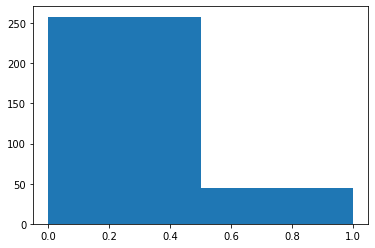


===histogram of restecg===
min	 0
25%	 0.0
75%	 1.0
iqr	 1.0
max	 2
range	 2
width	 0.29777103662286136
# bins	 7


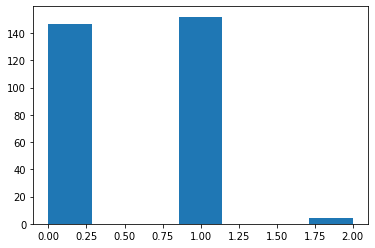


===histogram of thalach===
min	 71
25%	 133.5
75%	 166.0
iqr	 32.5
max	 202
range	 131
width	 9.677558690242995
# bins	 14


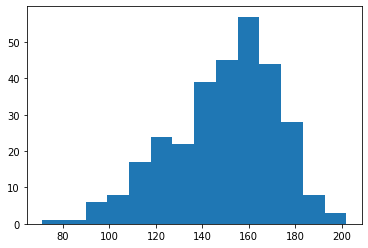


===histogram of exang===
min	 0
25%	 0.0
75%	 1.0
iqr	 1.0
max	 1
range	 1
width	 0.29777103662286136
# bins	 4


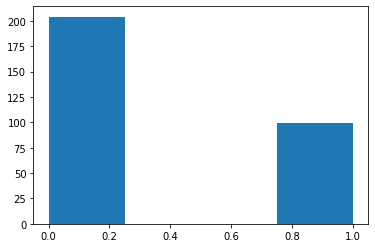


===histogram of oldpeak===
min	 0.0
25%	 0.0
75%	 1.6
iqr	 1.6
max	 6.2
range	 6.2
width	 0.4764336585965782
# bins	 14


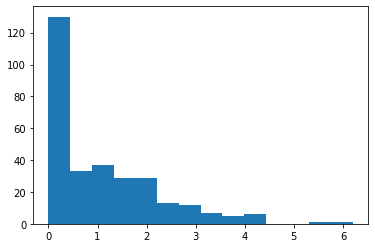


===histogram of slope===
min	 0
25%	 1.0
75%	 2.0
iqr	 1.0
max	 2
range	 2
width	 0.29777103662286136
# bins	 7


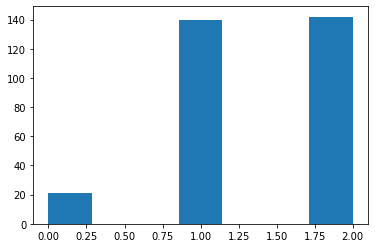


===histogram of ca===
min	 0
25%	 0.0
75%	 1.0
iqr	 1.0
max	 4
range	 4
width	 0.29777103662286136
# bins	 14


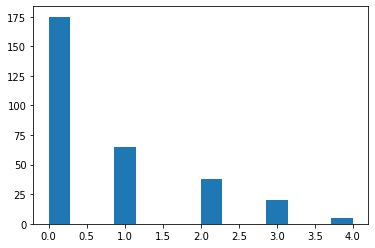


===histogram of thal===
min	 0
25%	 2.0
75%	 3.0
iqr	 1.0
max	 3
range	 3
width	 0.29777103662286136
# bins	 11


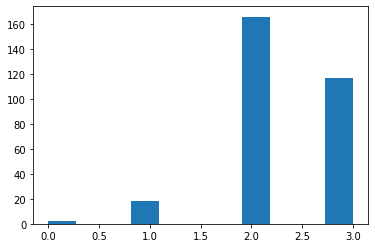


===histogram of target===
min	 0
25%	 0.0
75%	 1.0
iqr	 1.0
max	 1
range	 1
width	 0.29777103662286136
# bins	 4


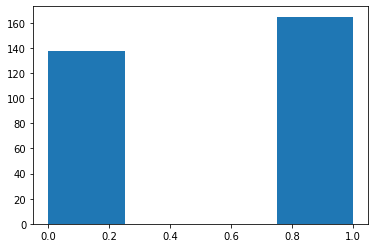

In [ ]:
# loop through the features (all numerical)
for column in df.columns:
    # find the range
    min_val = df[column].min()
    max_val = df[column].max()
    range_val = max_val - min_val
    # find the interquartile range
    p25, p75 = (df[column].quantile(q=q) for q in (0.25, 0.75))
    iqr = p75 - p25
    # calculate the bin width
    # using Freedman–Diaconis' choice
    n = df[column].shape[0]
    width = (2 * iqr * (n**(-1/3)))
    # calculate the number of bins
    # if ZERO IQR, use 2 bins
    if (iqr):
        n_bins = math.ceil(range_val/width)
    else:
        n_bins = 2
        width = range_val/n_bins
    # end if (iqr)
    # print the parameters we calculated
    print(fr"===histogram of {column}===")
    print('min\t', min_val)
    print('25%\t', p25)
    print('75%\t', p75)
    print('iqr\t', iqr)
    print('max\t', max_val)
    print('range\t', range_val)
    print('width\t', width)
    print('# bins\t', n_bins)
    # plot for this feature
    plt.hist(df[column].values, n_bins)
    # place the plot here
    plt.show()
    print()
# next column

This time, we had to deal with an $I\!Q\!R = 0$. In that case, I assumed $k := 2$ bins and bin width $h \approx: \frac{\max\{X\} - \min\{X\}}k$.

We can see that
* the label `[13]` "target" is a non-long tail distribution.
* the `[0]` age, `[1]` sex, `[2]` chest pain, `[3]` resting BPS, `[4]` cholesterol, `[5]` fasting blood sugar, `[6]` resting ECG, `[7]` maximum `thal` achieved, `[8]` exercise-induced angina, `[9]` `oldpeak`, `[10]` slope of peak, `[11]` number of major vessel, and `[12]` `thal` are long-tail distributions.

In [ ]:
cols = df.columns
# all numerical columns
i_cols = set(range(cols.shape[0]))

# We can see that
# * the label `[13]` "target" is a non-long tail distribution.
i_non_longtails = [13]
# * the `[0]` age, `[1]` sex, `[2]` chest pain, `[3]` resting BPS,
#   `[4]` cholesterol, `[5]` fasting blood sugar, `[6]` resting ECG,
#   `[7]` maximum `thal` achieved, `[8]` exercise-induced angina,
#   `[9]` `oldpeak`, `[10]` slope of peak, `[11]` number of major
#   vessel, and `[12]` `thal` are long-tail distributions.
i_longtails = list(i_cols - set(i_non_longtails))

# split the long tail distributions and non-long tail distributions
df_longtail_cols = cols[list(i_longtails)]
df_non_longtail_cols = cols[i_non_longtails]

# print the distribution by type
print(r'===columns by distribution===')
print(r"long tails: {}".format(df_longtail_cols))
print(r"non-long tails: {}".format(df_non_longtail_cols))

# replace missing long tails with medians
for column in df_longtail_cols:
    median = df[column].median()
    df[column] = df[column].fillna(median)
# next lt_column in df_longtail_cols

# for missing non-long tails, replace with mean
for column in df_non_longtail_cols:
    mean = df[column].mean()
    df[column] = df[column].fillna(mean)
# next column in df_non_longtail_cols

# confirm that there are no missing values
print(r'===Any still missing?===')
print(df.isna().sum() != 0)

===columns by distribution===
long tails: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')
non-long tails: Index(['target'], dtype='object')
===Any still missing?===
age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool


We check the correlations of each pair of features to find redundant features that can be eliminited.

In [ ]:
# calculate the correlation matrix
hcorr = df.corr()
# display using gradients
hcorr.style.background_gradient()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


There is no strong correlation between any pair of features.

To see if target will be balanced, let us view it more clearly using the bar plot.

target
1    165
0    138
Name: target, dtype: int64
rate of difference = 0.1782178217821782


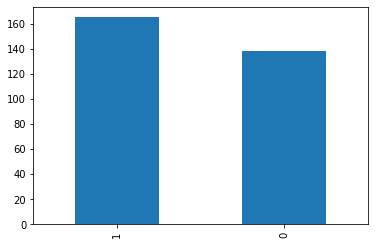

In [ ]:
# find the label and its label counts
label = df.columns[-1]
label_counts = df[label].value_counts()
r_diff = 2*abs(label_counts[0] - label_counts[1])/(label_counts[0] + label_counts[1])

# print and bar plot of the label
print(label)
print(label_counts)
print(r"rate of difference = {}".format(r_diff))
label_counts.plot(kind=r'bar')
plt.show()

The relative rate of difference is about $18\,\%$, which is significant. Thus, the data is somewhat imbalanced.

### 2.2 Split the data into two subsets and normalize the features of samples

* Split the dataset into the train_val set and testing set. 
* Normalize features

In [ ]:
P_TEST_PREADJ = 0.2                 # proportion of testing data, before adjusting
N_FOLDS = 10                        # we will use the 10-fold cross-validation

# adjust proportion testing so the folds are even
N_TEST_PREADJ = math.ceil(N_SAMPS * P_TEST_PREADJ)
N_TRAIN_PREADJ = (N_SAMPS - N_TEST_PREADJ)
FOLD_SIZE, REM_TO_TEST = divmod(N_TRAIN_PREADJ, N_FOLDS)
N_TEST_EXP = (N_TEST_PREADJ + REM_TO_TEST)
N_TRAIN_EXP = (N_SAMPS - N_TEST_EXP)
P_TEST = (N_TEST_EXP/N_SAMPS)

# split X, y
y = df[label].values
Xdf = df.drop(label, axis=1)
X = Xdf.values
# split training, testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=P_TEST, random_state=SEED)
N_TRAIN = X_train.shape[0]
N_TEST = X_test.shape[0]
print(r'# samples for training =', N_TRAIN)
print(r'# samples for testing =', N_TEST)

# samples for training = 240
# samples for testing = 63


Next normalize. Start by finding outliers ($1.5\,I\!Q\!R$s outside of the range $[Q_1, Q_3]$) on $\mathbf{x}$'s data frame.

In [ ]:
# find the interquartile range
q1, q3 = (Xdf.quantile(q=q) for q in np.array([1, 3])*0.25)
iqr = q3 - q1
# calculate limits of the outlier
inlier_min = (q1 - 1.5*iqr)
inlier_max = (q3 + 1.5*iqr)
# find any values out of range
outliers = ((Xdf < inlier_min) | (Xdf > inlier_max))
# print the limits
print(r'===outlier lower limit===')
print(inlier_min)
print()
print(r'===outlier upper limit===')
print(inlier_max)
print()
# print whether any outliers
print(r'===has outliers?===')
print(outliers.any())

===outlier lower limit===
age          27.25
sex          -1.50
cp           -3.00
trestbps     90.00
chol        115.75
fbs           0.00
restecg      -1.50
thalach      84.75
exang        -1.50
oldpeak      -2.40
slope        -0.50
ca           -1.50
thal          0.50
dtype: float64

===outlier upper limit===
age          81.25
sex           2.50
cp            5.00
trestbps    170.00
chol        369.75
fbs           0.00
restecg       2.50
thalach     214.75
exang         2.50
oldpeak       4.00
slope         3.50
ca            2.50
thal          4.50
dtype: float64

===has outliers?===
age         False
sex         False
cp          False
trestbps     True
chol         True
fbs          True
restecg     False
thalach      True
exang       False
oldpeak      True
slope       False
ca           True
thal         True
dtype: bool


Well, the resting BPS, cholesterol, fasting blood sugar, maximum `thal` achieved, `oldpeak`, number of major blood vessels, and `thal` each have outliers. Since at least 1 column has outliers, we will use standardization (Z-score normalization), rather than min-max normalization.

In [ ]:
# standardization
means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)

# find the z-scores, replacing X_train, X_test
X_train, X_test = ((X - means)/stds for X in (X_train, X_test))

# print the statistics (sampled) to verify information
print(r'===standardized X_train statistics===')
print(pd.DataFrame(X_train).describe())

===standardized X_train statistics===
                 0             1             2             3             4   \
count  2.400000e+02  2.400000e+02  2.400000e+02  2.400000e+02  2.400000e+02   
mean   7.401487e-18  1.480297e-17 -3.330669e-17  4.329870e-16  2.442491e-16   
std    1.002090e+00  1.002090e+00  1.002090e+00  1.002090e+00  1.002090e+00   
min   -2.776088e+00 -1.375342e+00 -9.737759e-01 -2.161592e+00 -2.188702e+00   
25%   -7.076304e-01 -1.375342e+00 -9.737759e-01 -6.142324e-01 -6.591125e-01   
50%    1.088662e-01  7.270918e-01  4.074376e-03 -1.909402e-02 -1.429353e-01   
75%    7.076304e-01  7.270918e-01  9.819247e-01  5.760444e-01  5.247802e-01   
max    2.449490e+00  7.270918e-01  1.959775e+00  3.670764e+00  6.013307e+00   

                 5             6             7             8             9   \
count  2.400000e+02  2.400000e+02  2.400000e+02  2.400000e+02  2.400000e+02   
mean  -1.073216e-16 -5.921189e-17  4.255855e-16  4.810966e-17 -1.850372e-16   
std    1.0020

We can verify the expected mean $\bar{x} \approx 0$ and standard deviation $S_{\mathbf{X}} \approx 1$ for each column by inspection.

### 2.3 Train the logistic regression model and select the hyperparameter with cross-validation

\begin{equation}
	\min_{\mathbf{w}} \sum_{i=1}^{n}\{\log(1+\exp(\mathbf{w}^T\mathbf{x}_i))-y_i\mathbf{w}^T\mathbf{x}_i \} + \lambda\|\mathbf{w}\|_2^2
\end{equation}

* Use the 10-fold cross-validation to select the hyperparameter $\lambda$.
* Search $\lambda$ from $\{10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10, 20, 50, 100\}$


In [ ]:
# set the seed
random.seed(SEED)

penalty = 'L2'.lower()             # use L2 norm for regularization

# search from candidate hyperparameters
reg_coeffs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20, 50, 100]

# create a numpy range of the sample indices of the training data
rand_i_samps = np.arange(N_TRAIN)
# shuffle these
shuffle(rand_i_samps)
# split them into folds
# we can also use a negative number to stand in for FOLD_SIZE
i_folds = rand_i_samps.reshape(N_FOLDS, FOLD_SIZE)  # sample indices per fold
print(i_folds)

[[ 45 113   9  85 105 197 209 132 231  44 126 193  29  78 115 140  21 123
  190 206 155 176  66 122]
 [149 222  84 228 202 119 162  61  73 233  12 239 100  27 201 109 138  10
  218  30  42 214 103  89]
 [  4 182 120  52   5 131  60   3  15  72 121 157 146 192  99 203   2 152
  225  81  98 148 145  47]
 [112 165  77  38  13  79 226  64  33   0 215 200 196  37 161 187  82  34
  210 159 111 175 106 204]
 [235  32 134 212 104  48 229 174  76 124 199 133 167 153  19 144 110 216
  181 171 128  65 172 238]
 [ 46  51 125 207 135 168  95 130  63 232 186  36 184 101 127 213 211  54
   16 156 102  80 223 170]
 [ 14  83 208 142  69 164 118 177 234 136  43  18  68  53  90  94  41  93
  116 198 191  25 219 180]
 [ 74  58 169 185  17  49 147  92 158 160  75 141  20  96  31 137 117  11
   67 217  88  91  24  97]
 [221 230  86 195 220  39 205  87 224 178  40 194   1  71 150 114  56 107
  227 179 166 183  50 143]
 [237 154 129  59  55  23   7   8 108 151  22 139 236 173  26 188  35  57
   62  70 189   6

In [ ]:
def reg_coeff_macro_accuracy(reg_coeff, penalty, X_train, y_train, i_folds):
    r'''
     Finds the macro-accuracy for the given regularization coefficient.
     @param reg_coeff = the regularization coefficient with which to train
     @param penalty = the norm to use for penalty
     @param X_train = the training data independent vectors
     @param y_train = the training data label
     @param i_folds = the indices by fold
     @yields each accuracy found.
     '''
    # find the macro-accuracy
    mac_acc = stats.mean(reg_coeff_accuracies(reg_coeff, penalty, X_train, y_train, i_folds))
    print(r"reg_coeff: {}, acc: {:.3f}".format(1.0/reg_coeff, mac_acc))
    return mac_acc
# end def reg_coeff_macro_accuracy(reg_coeff, penalty, X_train, y_train, i_folds)

def reg_coeff_accuracies(reg_coeff, penalty, X_train, y_train, i_folds):
    r'''
     Yields the accuracies for the given regularization coefficient.
     @param reg_coeff = the regularization coefficient with which to train
     @param penalty = the norm to use for penalty
     @param X_train = the training data independent vectors
     @param y_train = the training data label
     @param i_folds = the indices by fold
     @yields each accuracy found.
     '''
    # for each fold (and its index) as the validation fold
    for ii_fold, i_valid in enumerate(i_folds):
        # skip the validation fold in the indices per fold
        i_train_folds = np.delete(i_folds, ii_fold, axis=0)
        # flatten the folds, i_valid is already a vector
        i_train = i_train_folds.reshape(-1)

        # get the corresponding datasets
        Xtr_train, ytr_train, Xtr_valid, ytr_valid = (var[k] for k in (i_train, i_valid) for var in (X_train, y_train))

        # train a logistic model on training-training set with reg_coeff
        clf = LogisticRegression(penalty=penalty, C=reg_coeff)
        clf.fit(Xtr_train, ytr_train)

        # check against the validation set
        ytr_valid_pred = clf.predict(Xtr_valid)
        acc = accuracy_score(ytr_valid, ytr_valid_pred)

        # return the accuracy
        yield acc
    # next ii_fold, i_valid
# end def reg_coeff_accuracies(reg_coeff, penalty, X_train, y_train, i_folds)

In [ ]:
# find each macro-accuracy
mac_acc_gen = (reg_coeff_macro_accuracy(reg_coeff, penalty, X_train, y_train, i_folds) for reg_coeff in reg_coeffs)
mac_accs = list(mac_acc_gen)
# find the maximum one
i_best_acc = np.argmax(mac_accs)
# get the corresponding regularization coefficient
best_reg_coeff = reg_coeffs[i_best_acc]
print(r'best reg coeff:', (1.0/best_reg_coeff))

reg_coeff: 99999.99999999999, acc: 0.550
reg_coeff: 10000.0, acc: 0.550
reg_coeff: 1000.0, acc: 0.692
reg_coeff: 100.0, acc: 0.804
reg_coeff: 10.0, acc: 0.821
reg_coeff: 1.0, acc: 0.829
reg_coeff: 0.1, acc: 0.825
reg_coeff: 0.05, acc: 0.825
reg_coeff: 0.02, acc: 0.825
reg_coeff: 0.01, acc: 0.825
best reg coeff: 1.0


In [ ]:
# train the model we found to all training data
clf = LogisticRegression(penalty=penalty, C=best_reg_coeff)
clf.fit(X_train, y_train)

LogisticRegression(C=1)

### 2.4 Evaluate the learned model

* Report the prediction accuracy, recall, precision, and F1 score.

* Use the bar plot to visulaize the elements of the learned model parameter vector $\mathbf{w}$. Some elements  have larger absolute values, while the others do not. Try to explain this phenomenon. 

In [ ]:
# predict on X_test
y_test_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_test_pred)       # accuracy
rcl = recall_score(y_test, y_test_pred)         # recall
prc = precision_score(y_test, y_test_pred)      # precision
f1s = f1_score(y_test, y_test_pred)             # f1 score

print("accuracy  : {:4.1f}%".format(acc*100))
print("recall    : {:4.1f}%".format(rcl*100))
print("precision : {:4.1f}%".format(prc*100))
print("F1 score  : {:4.1f}%".format(f1s*100))

accuracy  : 85.7%
recall    : 84.8%
precision : 87.5%
F1 score  : 86.2%


In [ ]:
# get the learned weights
W = clf.coef_
# flatten weights to a vector
weights = W.flatten()
# get the weight magnitude
w_mag = abs(W).flatten()
w_mag

array([0.08241681, 0.78407908, 0.81629728, 0.26990796, 0.17905568,
       0.0910946 , 0.27753769, 0.39058234, 0.51287194, 0.67722098,
       0.43610409, 0.78989159, 0.56001553])

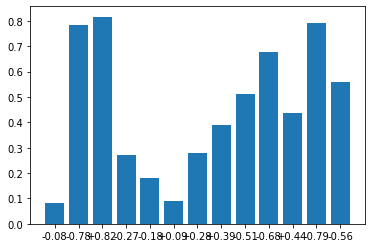

In [ ]:
# plot the bar graph
# the bar graph from the data frame would be too compact, so we use plt.bar.
# 2 significant figures shows all 13 independent features.
plt.bar(["{:+.2f}".format(weight) for weight in weights], w_mag)
plt.show()

The weights with the lower absolute values represent features that are not as important in determining the label for the model. Insignificant weights may be dropped to find a more generalized model. For example, let's assume that any weight below $15\,\%$ is insignificant and repeat the training and testing.

In [ ]:
# check if the weight is significant
SIG_MIN = 0.15
i_sig_X = (w_mag >= SIG_MIN)
print(r"===weight is significant (> {}%)?===".format(SIG_MIN*100))
print(i_sig_X)
print()

print(r'===columns removed===')
print(Xdf.columns[~i_sig_X])
print()

# remove insignificant weights from training data
sigX_train = X_train[:, i_sig_X]
# remove insignificant weights from training data
sigX_test = X_test[:, i_sig_X]

print(r'===dimensionality===')
print(r'X_train', sigX_train.shape)
print(r'X_test', sigX_test.shape)
print()

# retrain the model
clf = LogisticRegression(penalty=penalty, C=best_reg_coeff)
clf.fit(sigX_train, y_train)

# predict on sigX_test
sigy_test_pred = clf.predict(sigX_test)
sigacc = accuracy_score(y_test, sigy_test_pred) # accuracy
sigrcl = recall_score(y_test, sigy_test_pred)   # recall
sigprc = precision_score(y_test, sigy_test_pred)# precision
sigf1s = f1_score(y_test, sigy_test_pred)       # f1 score

print(r'===scoring===')
print("accuracy  : {:4.1f}%".format(sigacc*100))
print("recall    : {:4.1f}%".format(sigrcl*100))
print("precision : {:4.1f}%".format(sigprc*100))
print("F1 score  : {:4.1f}%".format(sigf1s*100))

===weight is significant (> 15.0%)?===
[False  True  True  True  True False  True  True  True  True  True  True
  True]

===columns removed===
Index(['age', 'fbs'], dtype='object')

===dimensionality===
X_train (240, 11)
X_test (63, 11)

===scoring===
accuracy  : 87.3%
recall    : 87.9%
precision : 87.9%
F1 score  : 87.9%


We find very similar scores to those that kept all weights. Thus the weights that we lost, (age and fasting blood sugar), do not seem to have as heavy a role in predicting heart disease as the other features.

### Conclusion

It is possible that there is an optimal weight, which may be found to produce a model that is both general and performs well by maximizing the minimum significance value.